+ title: Natural Language Processing of German texts - Part 3: Introducing transformer models to predict ratings
+ date: 2020-07-06
+ tags: python, NLP, classification, BERT, neural-networks, tensorflow, transformers
+ Slug: binary-text-classification-predict-ratings-part3-transformer-neural-network-bert
+ Category: Python
+ Authors: MC
+ Summary: Using a unique German data set containing ratings and comments on doctors, we build a Binary Text Classifier. In this third part, we introduce a state of the art model based on the transformer architecture, namely BERT. Using the transformers library for tensorflow, we push our ability to predict the sentiment of comments towards its limit.

### Motivation

In the [first part]({filename}/doctors_nlp1.ipynb) of this series, we implemented a complete machine-learning workflow for binary text classification. Using a unique German data set, we achieved decent results in predicting doctor ratings from patients' text comments. In the [second part]({filename}/doctors_nlp2.ipynb) we introduced the concept of word embeddings and built a LSTM neural network in tensorflow, which significantly improved our predictions.  
In this post, we will further improve our model and achieve tremendous results in predicting a comment's sentiment. For this, we will introduce a state of the art NLP model based on the transformer architecture. Bidirectional Encoder Representations from Transformers (BERT) combines multiple novel approaches and has significantly surpassed former models in many language related tasks. As before, we will follow this work flow:

<br>
<a class=mybox href="./img/nlp/nlp_workflow.png" title="A typical NLP machine learning workflow (click to enlarge)">
<img alt="Chart depicting a typical NLP workflow" src="https://github.com/mc51/blog_posts/blob/master/img/nlp/nlp_workflow.png?raw=1" style="margin:auto; display:block; width:800;">
</a>
<center><sup>A typical NLP machine-learning workflow (own illustration)</sup></center>
<br>

The cleaning and pre-processing will be identical to [part 2]({filename}/doctors_nlp2.ipynb). For the feature creation and the modeling, we will use the Hugging Face implementation of [transformers](https://github.com/huggingface/transformers) for Tensorflow 2.0. Transformers provides a general architecture implementation for several state of the art models in the natural language domain. We will use one of the most exciting ones, namely BERT.  
In the following notebook, we will go through this process step by step.  
<br>
You can download this notebook or follow along in an interactive version of it on <a href="https://mybinder.org/v2/gh/mc51/blog_posts/master?filepath=doctors_nlp3.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open on Binder" style="display:inline;"></a>  and <a href="https://colab.research.google.com/github/mc51/blog_posts/blob/master/doctors_nlp3.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" style="display:inline;"/></a>.

### Setup / Data set / cleaning / pre processing

As this is not the focus of this post, we will go through these steps rather quickly. If you need a refresher, check out the [first]({filename}/doctors_nlp1.ipynb) and [second post]({filename}/doctors_nlp2.ipynb) again.  

We'll be using the same data as before. You can take a look at it on [data.world](https://data.world/mc51/german-language-reviews-of-doctors-by-patients) or directly download it from [here](https://query.data.world/s/v5xl53bs2rgq476vqy7cg7xx2db55y).  
As in the second part, we will need to use a [TPU](https://cloud.google.com/tpu/docs/colabs) because of the high computational demand of BERT. While you can get away with using GPUs, you won't stand any chance to run this on a CPU. Luckily, the notebooks on Google Colab offer free TPU usage. If you want to replicate this post, your best bet is to start there.

In [ ]:
# Needed on Google Colab
import os
if os.environ.get('COLAB_GPU', False):
    !pip install -U transformers
    from google.colab import drive
    drive.mount("/drive")

In [2]:
import nltk
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings

pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
print(tf.__version__)

2.2.0


Executing this on Colab will make sure that our model runs on a TPU if available and falls back to GPU / CPU otherwise:

In [3]:
# Try to run on TPU if available
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.111.30.122:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.111.30.122:8470
INFO:tensorflow:Clearing out eager caches
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:

In our case, we are running on a TPU with eight cores. This will give us an immense speed up!  
As before, we first download and extract our data:

In [4]:
# store current path and download and extract data there
CURR_PATH = !pwd
!wget -O reviews.zip https://query.data.world/s/v5xl53bs2rgq476vqy7cg7xx2db55y
!unzip reviews.zip

--2020-07-11 09:23:05--  https://query.data.world/s/v5xl53bs2rgq476vqy7cg7xx2db55y
Saving to: ‘reviews.zip’

reviews.zip             [    <=>             ]  42.94M  60.4MB/s    in 0.7s    

2020-07-11 09:23:06 (60.4 MB/s) - ‘reviews.zip’ saved [45022322]

Archive:  reviews.zip
  inflating: german_doctor_reviews.csv  


In [31]:
# PARAMETERS
PATH_DATA = CURR_PATH[0]
PATH_GDRIVE_TMP = "/drive/My Drive/tmp/"  # Google Drive

Let's load the data set and create our target variable. Positive ratings (one or two) will be considered as good and negative ones (five or six) as negative. As before, we ignore neutral ratings:

In [ ]:
# read data from csv
data = pd.read_csv(PATH_DATA + "/german_doctor_reviews.csv")

# Create binary grade, class 1-2 or 5-6  = good or bad
data["grade_bad"] = 0
data.loc[data["rating"] >= 3, "grade_bad"] = np.nan
data.loc[data["rating"] >= 5, "grade_bad"] = 1

data.head(2)

,comment,rating,grade_bad
0,"Ich bin franzose und bin seit ein paar Wochen in muenchen. Ich hatte Zahn Schmerzen und mein Kollegue hat mir Dr mainka empfohlen. Ich habe schnell ein Termin bekommen, das Team war nett und meine schmerzen sind weg!! Ich bin als Angst Patient sehr zurieden!!",2.0,0.0
1,"Dieser Arzt ist das unmöglichste was mir in meinem Leben je begegnet ist,er ist unfreundlich ,sehr herablassend und medizinisch unkompetent.Nach seiner Diagnose bin ich zu einem anderen Hautarzt gegangen der mich ordentlich behandelt hat und mir auch half.Meine Beschweerden hatten einen völlig anderen Grund.<br />\nNach seiner "" Behandlung "" und Diagnose ,waren seine letzten Worte .....und tschüss.Alles inerhalb von ca 5 Minuten.",6.0,1.0


Our cleaning and pre-processing strategy will be almost identical to the [second post]({filename}/doctors_nlp2.ipynb). We will keep the text structure unchanged and only tidy it up a bit. The only difference to before is that we won't transform the texts to lowercase:


In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))


def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Now, we can we apply this pre-processing and cleaning to our original data:

In [ ]:
%%time
# Clean Comments
data["comment_clean"] = data.loc[data["comment"].str.len() > 20, "comment"]
data["comment_clean"] = data["comment_clean"].map(
    lambda x: clean_text(x, for_embedding=True) if isinstance(x, str) else x
)

CPU times: user 3min 47s, sys: 236 ms, total: 3min 47s
Wall time: 3min 47s


This is how the final comments will look like:

In [ ]:
# Drop Missing
data = data.dropna(axis="index", subset=["grade_bad", "comment_clean"]).reset_index(
    drop=True
)
data = data[["comment_clean", "grade_bad"]]
data.columns = ["text", "label"]
data.head(2)
# data.to_csv(PATH_GDRIVE_TMP + "/data.csv", index=False)

,text,label
0,"Ich bin franzose und bin seit ein paar Wochen in muenchen . Ich hatte Zahn Schmerzen und mein Kollegue hat mir Dr mainka empfohlen . Ich habe schnell ein Termin bekommen , das Team war nett und meine schmerzen sind weg ! ! Ich bin als Angst Patient sehr zurieden ! !",0.0
1,"Dieser Arzt ist das unmöglichste was mir in meinem Leben je begegnet ist er ist unfreundlich , sehr herablassend und medizinisch unkompetent Nach seiner Diagnose bin ich zu einem anderen Hautarzt gegangen der mich ordentlich behandelt hat und mir auch half Meine Beschweerden hatten einen völlig anderen Grund . Nach seiner Behandlung und Diagnose , waren seine letzten Worte ... ..und tschüss Alles inerhalb von ca Minuten .",1.0


In [6]:
# skip pre processing if done before
# data = pd.read_csv(PATH_GDRIVE_TMP + "/data.csv")

### A brief background on transformers and BERT

You've made it to the interesting part. But before we further dive into the code, let's get a brief background on transformers and BERT. Transformer models, similar to RNNs (e.g. the LSTM we used in [part 2]({filename}/doctors_nlp2.ipynb)), are designed to handle sequences of data well. They shine at picking up relations between various inputs in an input sequence. Hence, they lend themselves perfectly for NLP tasks where such associations correspond to semantic relationships. This is also a convenient property of LSTM models, e.g. the one we implemented previously. It was able to learn relationships between sequences of the input, e.g. word vectors. For LSTMs, however, this ability is limited. Because inputs are processed in sequence, in practice, at the end of a long sentence information from the beginning will often be lost. Also, computational limits come into play really quick for the same reason. Transformer models address this issue by using the so called `attention` mechanism. This allows them to process inputs in a non sequential way which allows for better parallelization. Following, computational efficiency is greatly improved. In addition, they learn associations between words even if those are far apart in a sentence. This is an outstanding improvement when trying to model language. It explains why transformers are at the foundation of most state of the art models and why they have surpassed former architectures like LSTMs.  
BERT is currently one of the most successful transformer architectures (although, this will change quickly as the speed of innovation at the moment is mind blowing). For a well illustrated and thorough introduction, check out [this article](http://jalammar.github.io/illustrated-bert/) by Jay Allamar. BERT has been developed by Google and has set new records on several language related tasks. Its main novelty is the introduction of bi-directionality. Previous models looked at inputs uni directionally, i.e. from left to right. In contrast, BERT also looks at them from right to left. The authors have proved that this leads to a deeper understanding of context in texts and increases performance significantly.  
As most other state of the art models, a lot of BERT's performance comes from sheer size. BERT large (24 layers, 16 attention heads, 340 million parameters) is trained on a huge text dataset in order to gain a thorough understanding of language in general. For this, it follows several ingenious unsupervised training strategies. Training such models is extremely computationally demanding and expensive. For all but big institutions and companies it is prohibitory.  
Fortunately, we can apply the principle of transfer learning to such models. That is, we can fine tune a pre trained model on a more specific task and dataset (which doesn't need to be that huge). In our case, we will simply add a classification layer to the pre trained BERT model. Then, we will do a supervised training on our labeled dataset. Consequently, we will mainly train our classifier layer while most other layers will only be minimally impacted. In a sense, we use the general language understanding of the pre trained model and improve its understanding of our unique domain. Moreover, we teach it to solve a specific task. In our case, this will be sentiment analysis in the form of a binary text classification.

### Feture Creation and Modeling

As mentioned before, we use the [`transformers`](https://github.com/huggingface/transformers) library. To stay consistent with our previous neural network model, we use the Tensorflow 2.0 implementation. In addition, this allows us to use the TPU on Google Colab without much trouble. Another invaluable advantage of the transformers library, is that several pre trained models are readily available for usage.  
BERT comes with its own Tokenizer. As with the model itself, we will use a pre trained version of the tokenizer. Here, we use a variant that has been specifically trained on German texts and made public. Hence, it already comes with a huge German vocabulary:



In [ ]:
# this will download and initialize the pre trained tokenizer
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

The inputs expected by BERT are very similar to the ones we've used before: they are just vectors containing integers which can be mapped to tokens by using a dictionary. The only difference is that BERT expects several "special" tokens. `[CLS]` stands for classification and marks the beginning of a new input to be classified. `[SEP]` marks the separation between sentences. Finally, `[PAD]` is used as a placeholder in order to pad all vectors to the same fixed length. The helper method `encode_plus` of the `Tokenizer` object deals with creating the numeric vectors while taking care of the extra tokens: 



In [11]:
MAXLEN = 192

def preprocess_text(data):
    """ take texts and prepare as input features for BERT 
    """
    input_ids = []
    # For every sentence...
    for comment in data:
        encoded_sent = tokenizer.encode_plus(
            text=comment,
            add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
            max_length=MAXLEN,  # Max length to truncate/pad
            pad_to_max_length=True,  # Pad sentence to max length
            return_attention_mask=False,  # attention mask not needed for our task
        )
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get("input_ids"))
    return input_ids

Before creating our features, let's check out the workings of the tokenizer with an example:

In [ ]:
# Original Comment and encoding outputs
comment = ["Ich liebe data-dive.com und meine Katze."]
input_ids = preprocess_text(comment)
print("Comment: ", comment)
print("Tokenized Comment: ", tokenizer.convert_ids_to_tokens(input_ids[0])[0:20])
print("Token IDs: ", input_ids[0][0:20])

Comment:  ['Ich liebe data-dive.com und meine Katze.']
Tokenized Comment:  ['[CLS]', 'Ich', 'liebe', 'dat', '##a', '-', 'di', '##ve', '.', 'c', '##om', 'und', 'meine', 'Katze', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Token IDs:  [3, 1671, 16619, 10453, 26903, 26935, 4616, 2304, 26914, 1350, 101, 42, 6667, 25285, 26914, 4, 0, 0, 0, 0]


First, you can see the special tokens being automatically added in the right places. Second, we see that some tokens simply correspond to regular words, i.e. "Ich" and "liebe". This will be the case for all words that are in the vocabulary. Here, that will amount to most regular German words. In contrast, unknown words get a special treatment. Instead of just being left out, as was the case with the FastText embeddings, they are split to shorter character sequences. For example "data", which is not a German word, becomes "dat" and "##a". This allows the model to still use these novel words.  
There is one more major difference between BERT's word embeddings and e.g. FastText's. Recall how vector representations of words with similar semantic meaning in FastText were similar, i.e. had a short distance between them. This allowed our model to group similar words together. BERT takes this one step further. A word's vector representation is not static anymore but depends on context. Consequently, the vector for "broke" is different when it's in a context of "money" vs. " a record". This immensely improves contextual awareness and might benefit predictions in many cases.  
Now, we apply the tokenization process to our data:

In [8]:
%%time
import pickle

input_ids = preprocess_text(data["text"])
# tokenization takes quite long
# we can save the result and load it quickly via pickle
pickle.dump(input_ids, open(PATH_GDRIVE_TMP + "/input_ids.pkl", "wb"))
# input_ids = pickle.load(open(PATH_GDRIVE_TMP+"/input_ids.pkl", "rb"))

CPU times: user 3.62 s, sys: 932 ms, total: 4.55 s
Wall time: 5.16 s


Next, we split out data into train and test for cross validation:

In [9]:
# Sample data for cross validation
train_ids, test_ids, train_labels, test_labels = train_test_split(
    input_ids, data["label"], random_state=1, test_size=0.25, shuffle=True
)
print(f"Train set: {len(train_ids)}\nTest set: {len(test_ids)}")

Train set: 253783
Test set: 84595


Here, we set the model parameters. `MAXLEN` is the max. number of tokens in our input. Longer inputs will be truncated to this. While greater lengths will yield better predictions, they also mean a greater computational toll. We differentiate between `BATCH_SIZE_PER_REPLICA` and `BATCH_SIZE` when we run on multiple GPUs or TPUs, as is the case on Google Colab. Each TPU core will deal with `BATCH_SIZE_PER_REPLICA` batches at a time. `EPOCHS` is simply the number of training iterations over the whole training set:

In [22]:
# Set Model Parameters
MAXLEN = MAXLEN
BATCH_SIZE_PER_REPLICA = 16
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
EPOCHS = 8
LEARNING_RATE = 1e-5
DATA_LENGTH = len(data)

As a last step before building our model, we need to prepare our dataset. Before, we used NumPy arrays as inputs. Here, we use the `tf.data.Dataset` class which offers several convenient methods:

In [23]:
def create_dataset(
    data_tuple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    buffer_size=DATA_LENGTH,
    train=False,
):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(
            buffer_size=buffer_size, reshuffle_each_iteration=True
        ).repeat(epochs)
    dataset = dataset.batch(batch_size)
    return dataset


train = create_dataset(
    (train_ids, train_labels), buffer_size=len(train_ids), train=True
)
test = create_dataset((test_ids, test_labels), buffer_size=len(test_ids))

Finally, we define a function that returns our model architecture:

In [24]:
def build_model(transformer, max_len=MAXLEN):
    """ add binary classification to pretrained model
    """
    input_word_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="input_word_ids"
    )
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = tf.keras.layers.Dense(1, activation="sigmoid")(cls_token)
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=out)
    model.compile(
        tf.keras.optimizers.Adam(lr=LEARNING_RATE),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

In the first step, we define an `Input` layer which expects our numeric vectors as input. Then, we add the pre trained transformer which receives the inputs from the previous layer. The output of the transformer is then fed into a `Dense` layer which finally outputs a probability for our input belonging to class 0 or 1.  
Now, we build our model by first downloading the pre trained BERT and passing it to our `build_model` function:

In [25]:
with strategy.scope():
    transformer_layers = TFBertModel.from_pretrained("bert-base-german-cased")
    model = build_model(transformer_layers, max_len=MAXLEN)
model.summary()

- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_bert_model_1 (TFBertModel ((None, 192, 768), (None, 109081344 
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 768)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 769       
Total params: 109,082,113
Trainable params: 109,082,113
Non-trainable params: 0
_________________________________________________________________


In total we have almost 110 Mio. trainable parameters. It's convenient that almost all of them have already been trained. Because we use the pre trained weights for them, they will only need to change ever so slightly. Still, it is a big model and even training on GPUs takes considerable time. So again, good thing that we can use TPUs.  
Next, we define callbacks that will be used during training. The `EartlyStopping` callback will stop the training if validation loss stops decreasing between epochs. This avoids overfitting. `ModelCheckpoint` saves checkpoints of the model after each epoch, so that training can be resumed. On Google Colab, you can currently only save TPU models in a Cloud Bucket but not on a mounted Google Drive. Hence, I commented out that part:

In [26]:
# Stop training when validation acc starts dropping
# Save checkpoint of model each period
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", verbose=1, patience=1, restore_best_weights=True
    ),
    # tf.keras.callbacks.ModelCheckpoint(
    #    PATH_GDRIVE_TMP + now + "_Model_{epoch:02d}_{val_loss:.4f}.h5",
    #    monitor="val_loss",
    #    save_best_only=True,
    #    verbose=1,
    # ),
]

Finally, time to get excited! We can now start the model training:

In [27]:
%%time
# Train using appropriate steps per epochs (go through all train data in an epoch)
steps_per_epoch = int(np.floor((len(train_ids) / BATCH_SIZE)))
print(
    f"Model Params:\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
    f"Learning rate: {LEARNING_RATE}"
)
hist = model.fit(
    train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=test,
    verbose=1,
    callbacks=callbacks,
)

Model Params:
batch_size: 128
Epochs: 8
Step p. Epoch: 1982
Learning rate: 1e-05
Epoch 1/8


1982/1982 [==============================] - 501s 253ms/step - accuracy: 0.9684 - loss: 0.0789 - val_accuracy: 0.9779 - val_loss: 0.0571
Epoch 2/8
1982/1982 [==============================] - 480s 242ms/step - accuracy: 0.9815 - loss: 0.0488 - val_accuracy: 0.9792 - val_loss: 0.0544
Epoch 3/8
1982/1982 [==============================] - 482s 243ms/step - accuracy: 0.9869 - loss: 0.0363 - val_accuracy: 0.9791 - val_loss: 0.0569
Epoch 00003: early stopping
CPU times: user 2min 4s, sys: 10.6 s, total: 2min 15s
Wall time: 25min 29s


The model converges really fast and stops early after only three epochs. This is because it already achieves the lowest validation loss in the second period:

[Text(0, 0.5, ''),
 [Text(0, 0, '1'), Text(0, 0, '2'), Text(0, 0, '3')],
 Text(0.5, 1.0, 'Model loss')]

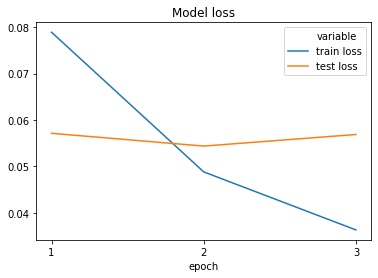

In [28]:
loss = pd.DataFrame(
    {"train loss": hist.history["loss"], "test loss": hist.history["val_loss"]}
).melt()
loss["epoch"] = loss.groupby("variable").cumcount() + 1
sns.lineplot(x="epoch", y="value", hue="variable", data=loss).set(
    title="Model loss",
    ylabel="",
    xticks=range(1, loss["epoch"].max() + 1),
    xticklabels=loss["epoch"].unique(),
)

Since the low loss value indicates that our model is already really good, we don't do any hyperparameter tuning. Also, our parameters were already chosen with good care. However, when looking for peak performance, it would be reasonable to compare different configurations. Natural starting points would be to:
1. Increasing the input length
2. Change the learning rate or use a dynamic rate adaption
3. Try different batch sizes

I'd expect to see some further but very marginal improvement from these steps.

### Evaluation 

Was this all worth it? Let's find out:

In [29]:
# predict on test set
pred = model.predict(test, batch_size=BATCH_SIZE, verbose=2, use_multiprocessing=True)

661/661 - 55s


In [30]:
# Load best model from Checkpoint
# model = load_model(PATH_GDRIVE_TMP+"BERT.h5", compile=False)
pred_class = (pred > 0.5).astype(int)
report = metrics.classification_report(test_labels, pred_class)
print(report)

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     76290
         1.0       0.88      0.92      0.90      8305

    accuracy                           0.98     84595
   macro avg       0.93      0.95      0.94     84595
weighted avg       0.98      0.98      0.98     84595



Let's recap our previous results: In [the first part]({filename}/doctors_nlp1.ipynb) we used a traditional classification method and achieved a decent macro f1-score of `0.9`. In [part two]({filename}/doctors_nlp1.ipynb), we improved the score to `0.93` using a LSTM neural network and FastText word embeddings. For our harder to predict class 1 (bad ratings), we had a precision of `0.86` and recall of `0.89`.  
Compared to that, our BERT approach is a significant improvement. We increase the macro f1 to `0.94` while getting a decent improvement in both, the precision and recall for class 1 . You might be fooled by the small increase of the absolute numbers and wonder why I'm talking about "big improvement". Well, we really need to put this into relation. The better a model already performs, the harder it gets to squeeze out further improvements. An increase from a f1 of `0.6` to `0.7` is usually easier to achieve and less impressive than an improvement from `0.95` to `0.97`. Think "pareto principle" and "decreasing marginal returns"! 


### Conclusion

In this third part of our series, we have further advanced our binary text classification model of German comments of patients on their doctors. We have introduced the transformer architecture and more specifically the BERT model. Using the HuggingFace `transformers` library for Python, we have fine tuned a pre trained German language BERT model. For that training, we have used a free Google Colab instance with a TPU. As a final result, we have significantly improved the capacity of our prediction model once more. The classifier is able to assign the correct sentiment to comments and predict their ratings with high proficiency.  
This concludes our search for the best possible classification model for our task. However, our NLP journey is not finished yet: In the next part of this series, we will use this data set to explore the capability of AIs to generate text. Using the GPT-2 neural network architecture, we will build a model that generates comments in German. Will our approach be able to create credible patient reviews in a medical context?
<br>